In [70]:
import gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from IPython.display import HTML
import base64
import os
import glob

print(gym.__version__)

0.26.2


In [71]:
# from gym import Wrapper

# class TimeDependentPenaltyWrapper(Wrapper):
#     def __init__(self, env):
#         super(TimeDependentPenaltyWrapper, self).__init__(env)
#         self.theta_threshold = 0.003  # radians (~2.86 degrees)
#         self.x_dot_threshold = 0.003  # cart velocity
#         self.current_step = 0

#     def reset(self, **kwargs):
#         # Reset the environment and step counter
#         self.current_step = 0
#         return self.env.reset(**kwargs)

#     def step(self, action):
#         # Step through the environment and increase the step count
#         self.current_step += 1
#         observation, reward, done, truncated, info = self.env.step(action)
        
#         x, x_dot, theta, theta_dot = observation

#         # Condition for being upright and still
#         is_upright = abs(theta) < self.theta_threshold
#         is_still = abs(x_dot) < self.x_dot_threshold

#         if is_upright and is_still:
#             reward = 100.0  # Large reward for upright and still
#         else:
#             # Time-dependent penalty for high velocity
#             velocity_penalty = self.current_step * abs(x_dot) * .001
#             reward = -velocity_penalty

#         return observation, reward, done, truncated, info

In [72]:
# Define the Q-Network
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1, hidden2):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, action_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Define the Epsilon-Greedy Policy
def epsilon_greedy_policy(state, q_network, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Corrected 'unsqueee' to 'unsqueeze'
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return torch.argmax(q_values, dim=1).item()

# Define the DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden1=128, hidden2=128, 
                 learning_rate=0.001, gamma=0.99, buffer_capacity=10000, batch_size=64, tau=0.001):
        """
        Initialize the DQN Agent.

        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Number of possible actions.
            hidden1 (int, optional): Number of neurons in the first hidden layer. Defaults to 128.
            hidden2 (int, optional): Number of neurons in the second hidden layer. Defaults to 128.
            learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.
            gamma (float, optional): Discount factor for future rewards. Defaults to 0.99.
            buffer_capacity (int, optional): Capacity of the replay buffer. Defaults to 10000.
            batch_size (int, optional): Number of samples per training batch. Defaults to 64.
            tau (float, optional): Soft update parameter. Defaults to 0.001.
        """
        # Initialize Q-Network
        self.q_network = DQN(state_dim, action_dim, hidden1, hidden2)
        self.target_network = DQN(state_dim, action_dim, hidden1, hidden2)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # Set target network to evaluation mode

        # Optimizer and Loss Function
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        # Replay Buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        self.batch_size = batch_size

        # Discount Factor
        self.gamma = gamma

        # Soft Update Parameter
        self.tau = tau

    def select_action(self, state, epsilon, action_dim):
        """
        Select an action using the epsilon-greedy policy.

        Args:
            state (np.array): Current state.
            epsilon (float): Current epsilon value for exploration.
            action_dim (int): Number of possible actions.

        Returns:
            int: Selected action.
        """
        return epsilon_greedy_policy(state, self.q_network, epsilon, action_dim)

    def store_experience(self, state, action, reward, next_state, done):
        """
        Store an experience tuple in the replay buffer.

        Args:
            state (np.array): Current state.
            action (int): Action taken.
            reward (float): Reward received.
            next_state (np.array): Next state.
            done (bool): Whether the episode has ended.
        """
        self.replay_buffer.push(state, action, reward, next_state, done)

    def sample_experiences(self):
        """
        Sample a batch of experiences from the replay buffer.

        Returns:
            tuple: Tuple containing batches of states, actions, rewards, next_states, and dones.
        """
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def update_q_network(self, states, actions, rewards, next_states, dones):
        """
        Update the Q-Network using a batch of experiences.

        Args:
            states (torch.Tensor): Batch of current states.
            actions (torch.Tensor): Batch of actions taken.
            rewards (torch.Tensor): Batch of rewards received.
            next_states (torch.Tensor): Batch of next states.
            dones (torch.Tensor): Batch of done flags.
        """
        # Compute Current Q-Values: Q(s, a)
        current_q = self.q_network(states).gather(1, actions)

        # Compute Next Q-Values: max_a Q(s', a') using Target Network
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0].unsqueeze(1)

        # Compute Target Q-Values: r + gamma * max_a Q(s', a') * (1 - done)
        target_q = rewards + self.gamma * next_q * (1 - dones)

        # Compute the Loss between Current Q and Target Q
        loss = self.loss_fn(current_q, target_q)

        # Perform Backpropagation and Optimization Step
        self.optimizer.zero_grad()  # Corrected 'zero' to 'zero_grad'
        loss.backward()
        self.optimizer.step()

        # Perform Soft Update of the Target Network
        self.soft_update_target_network()

    def soft_update_target_network(self):
        """
        Perform a soft update of the target network's weights.
        """
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def train_step(self):
        """
        Perform a single training step by sampling experiences and updating the Q-Network.
        """
        # Check if Replay Buffer has Enough Samples
        if len(self.replay_buffer) < self.batch_size:
            return  # Not enough experiences to train

        # Sample a Batch of Experiences
        states, actions, rewards, next_states, dones = self.sample_experiences()

        # Convert Batches to Tensors
        states = torch.FloatTensor(states)          # Shape: [batch_size, state_dim]
        actions = torch.LongTensor(actions).unsqueeze(1)  # Shape: [batch_size, 1]
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # Shape: [batch_size, 1]
        next_states = torch.FloatTensor(next_states)      # Shape: [batch_size, state_dim]
        dones = torch.FloatTensor(dones).unsqueeze(1)      # Shape: [batch_size, 1]

        # Update the Q-Network
        self.update_q_network(states, actions, rewards, next_states, dones)


Episode 1/500 - Total Reward: 17.0 - Epsilon: 0.9950
Episode 2/500 - Total Reward: 16.0 - Epsilon: 0.9900
Episode 3/500 - Total Reward: 17.0 - Epsilon: 0.9851
Episode 4/500 - Total Reward: 46.0 - Epsilon: 0.9801
Episode 5/500 - Total Reward: 26.0 - Epsilon: 0.9752
Episode 6/500 - Total Reward: 26.0 - Epsilon: 0.9704
Episode 7/500 - Total Reward: 9.0 - Epsilon: 0.9655
Episode 8/500 - Total Reward: 56.0 - Epsilon: 0.9607
Episode 9/500 - Total Reward: 32.0 - Epsilon: 0.9559
Episode 10/500 - Total Reward: 21.0 - Epsilon: 0.9511


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 11/500 - Total Reward: 15.0 - Epsilon: 0.9464
Episode 12/500 - Total Reward: 21.0 - Epsilon: 0.9416
Episode 13/500 - Total Reward: 22.0 - Epsilon: 0.9369
Episode 14/500 - Total Reward: 24.0 - Epsilon: 0.9322
Episode 15/500 - Total Reward: 14.0 - Epsilon: 0.9276
Episode 16/500 - Total Reward: 17.0 - Epsilon: 0.9229
Episode 17/500 - Total Reward: 21.0 - Epsilon: 0.9183
Episode 18/500 - Total Reward: 20.0 - Epsilon: 0.9137
Episode 19/500 - Total Reward: 28.0 - Epsilon: 0.9092
Episode 20/500 - Total Reward: 14.0 - Epsilon: 0.9046
Episode 21/500 - Total Reward: 14.0 - Epsilon: 0.9001
Episode 22/500 - Total Reward: 12.0 - Epsilon: 0.8956
Episode 23/500 - Total Reward: 17.0 - Epsilon: 0.8911
Episode 24/500 - Total Reward: 19.0 - Epsilon: 0.8867
Episode 25/500 - Total Reward: 13.0 - Epsilon: 0.8822
Episode 26/500 - Total Reward: 13.0 - Epsilon: 0.8778
Episode 27/500 - Total Reward: 35.0 - Epsilon: 0.8734
Episode 28/500 - Total Reward: 15.0 - Epsilon: 0.8691
Episode 29/500 - Total Rewar

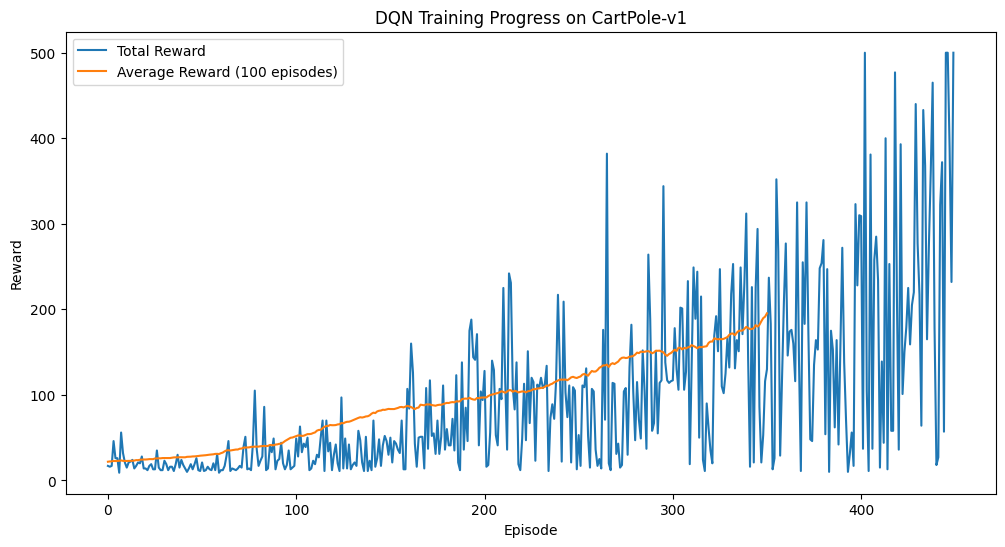

Video will be saved to: /Users/matthew/Documents/ml_projects/videos/


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/matthew/Documents/ml_projects/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/matthew/Documents/ml_projects/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/matthew/Documents/ml_projects/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/matthew/Documents/ml_projects/videos/rl-video-episode-0.mp4
Episode finished with total reward: 500.0
Latest video file: /Users/matthew/Documents/ml_projects/videos/rl-video-episode-0.mp4


In [73]:

# Define the Training Function
def train_dqn_agent():
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    hidden1 = 128
    hidden2 = 128
    learning_rate = 0.001
    gamma = 0.99
    buffer_capacity = 10000
    batch_size = 64
    num_episodes = 500
    tau = 0.001

    epsilon_start = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995

    agent = DQNAgent(state_dim, action_dim, hidden1, hidden2, learning_rate, gamma, buffer_capacity, batch_size, tau)

    epsilon = epsilon_start

    rewards_history = []
    avg_rewards_history = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state, epsilon, action_dim)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.store_experience(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Update Q Network
            agent.train_step()

        # Decay Epsilon after Each Episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        rewards_history.append(total_reward)

        if episode >= 100:
            avg_reward = np.mean(rewards_history[-100:])
            avg_rewards_history.append(avg_reward)
            print(f"Episode {episode}/{num_episodes} - Total Reward: {total_reward} - Average Reward: {avg_reward:.2f} - Epsilon: {epsilon:.4f}")

            if avg_reward >= 195.0:
                print(f"Environment solved in {episode} episodes!")
                break

        else:
            print(f"Episode {episode}/{num_episodes} - Total Reward: {total_reward} - Epsilon: {epsilon:.4f}")

    env.close()     

    # Plotting the Rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, label='Total Reward')
    plt.plot(avg_rewards_history, label='Average Reward (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('DQN Training Progress on CartPole-v1')
    plt.legend()
    plt.show()   
    return agent

#video recording
import gym

def record_cartpole_video(agent, env_name="CartPole-v1", video_folder="/Users/matthew/Documents/ml_projects/videos/"):
    import os
    import glob
    from IPython.display import HTML, display
    import base64

    def display_video_inline(video_path, width=600):
        if not os.path.exists(video_path):
            print(f"Video file not found at: {video_path}")
            return
        mp4 = open(video_path, 'rb').read()
        data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
        return display(HTML(f"""<video width="{width}" controls>
                        <source src="{data_url}" type="video/mp4" />
                        Your browser does not support the video tag.
                       </video>"""))

    # Ensure the video directory exists
    os.makedirs(video_folder, exist_ok=True)
    print(f"Video will be saved to: {video_folder}")
    
    # Initialize environment with render_mode
    env = gym.make(env_name, render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.select_action(state, epsilon=0.0, action_dim=env.action_space.n)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        total_reward += reward
    
    env.close()
    print(f"Episode finished with total reward: {total_reward}")
    
    # Retrieve the latest video
    video_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    if not video_files:
        print("No video recorded.")
        return
    
    latest_video = max(video_files, key=os.path.getctime)
    print(f"Latest video file: {latest_video}")
    
    # Display the video inline
    display_video_inline(latest_video)


if __name__ == "__main__":
    trained_agent = train_dqn_agent()

    record_cartpole_video(trained_agent)



In [74]:

video_folder = "/Users/matthew/Documents/ml_projects/videos/"
video_files = glob.glob(os.path.join(video_folder, "*.mp4"))
print(f"Video files in {video_folder}:")
for video in video_files:
    print(video)



Video files in /Users/matthew/Documents/ml_projects/videos/:
/Users/matthew/Documents/ml_projects/videos/rl-video-episode-0.mp4
